In [2]:
# Caso de Estudio: Retención de Usuarios - FitNess App

In [3]:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Aquí estaba el error, ahora está corregido
import os

print("✅ Motor listo.")

✅ Motor listo.


In [4]:
# 2. Configuración de ubicación y rutas (Seguro y Privado)
import os

# Definimos cómo se llama la carpeta de tu proyecto
nombre_buscado = "Proyecto-FitnessApp"

# Lógica para saltar a la carpeta del proyecto si el kernel inicia en la carpeta de usuario
if nombre_buscado not in os.getcwd():
    # Construimos la ruta dinámica al escritorio
    ruta_escritorio = os.path.join(os.path.expanduser("~"), "Desktop", "TUP-UTN", "Materias", "Intro-Analisis-Datos", nombre_buscado)
    
    if os.path.exists(ruta_escritorio):
        os.chdir(ruta_escritorio)

# AQUÍ SE DEFINE LA VARIABLE QUE TE FALTA
path_raw = 'data/raw'

# Verificación final
if os.path.exists(path_raw):
    print(f"✅ Entorno listo en el proyecto: [{os.path.basename(os.getcwd())}]")
    print(f"✅ Carpeta de datos validada: {path_raw}")
else:
    print("❌ ERROR: No se encuentra la carpeta 'data/raw'.")
    print("📍 Ubicación actual de Python:", os.path.basename(os.getcwd()))

✅ Entorno listo en el proyecto: [Proyecto-FitnessApp]
✅ Carpeta de datos validada: data/raw


In [5]:
# 3. Carga de datos y creación de copias de seguridad
try:
    # Carga desde la ruta relativa validada anteriormente
    actividad_raw = pd.read_csv(os.path.join(path_raw, 'actividad_usuarios.csv'))
    demografia_raw = pd.read_json(os.path.join(path_raw, 'datos_demograficos.json'), encoding='utf-8-sig') # Nota: agregamos encoding por seguridad
    suscripciones_raw = pd.read_excel(os.path.join(path_raw, 'suscripciones_usuarios.xlsx'))
    progreso_raw = pd.read_csv(os.path.join(path_raw, 'progreso_planes.csv'))
    nutricion_raw = pd.read_excel(os.path.join(path_raw, 'interacciones_nutricion.xlsx'))

    # Creación de copias de trabajo
    df_actividad = actividad_raw.copy()
    df_demografia = demografia_raw.copy()
    df_suscripciones = suscripciones_raw.copy()
    df_progreso = progreso_raw.copy()
    df_nutricion = nutricion_raw.copy()

    print("✅ Datos cargados y copias de seguridad creadas exitosamente.")

except Exception as e:
    print(f"❌ Error al cargar los archivos: {e}")

✅ Datos cargados y copias de seguridad creadas exitosamente.


In [6]:
# 4. Auditoría de Identificadores (Caza de nulos y formatos)
print("🔎 CHEQUEO DE NULOS EN ID_USUARIO:")
print(f"Actividad: {df_actividad['ID_Usuario'].isnull().sum()}")
print(f"Demografía: {df_demografia['ID_Usuario'].isnull().sum()}")

# Chequeo de espacios en blanco (error común de Software Developer)
ejemplo_id = df_actividad['ID_Usuario'].iloc[0]
print(f"\n📏 Prueba de longitud del ID '{ejemplo_id}': {len(str(ejemplo_id))} caracteres")

# Verificamos si hay espacios que sobran
if len(str(ejemplo_id)) != len(str(ejemplo_id).strip()):
    print("⚠️ ALERTA: Se detectaron espacios en blanco en los IDs. Necesitan limpieza.")
else:
    print("✅ Formato de IDs parece limpio.")

🔎 CHEQUEO DE NULOS EN ID_USUARIO:
Actividad: 0
Demografía: 0

📏 Prueba de longitud del ID 'USR-04725': 9 caracteres
✅ Formato de IDs parece limpio.


In [7]:
# 5. Unificación de tablas (Merge Estratégico)
# Empezamos con Actividad y sumamos Demografía
df_maestro = df_actividad.merge(df_demografia, on='ID_Usuario', how='left')

# Sumamos Suscripciones
df_maestro = df_maestro.merge(df_suscripciones, on='ID_Usuario', how='left')

# Sumamos Nutrición (contando interacciones por usuario para no duplicar filas)
nutricion_resumen = df_nutricion.groupby('ID_Usuario').size().reset_index(name='Interacciones_Nutricion')
df_maestro = df_maestro.merge(nutricion_resumen, on='ID_Usuario', how='left')

# Rellenamos nulos en interacciones con 0 (quien no aparece es porque no la usó)
df_maestro['Interacciones_Nutricion'] = df_maestro['Interacciones_Nutricion'].fillna(0)

print(f"✅ Dataset Maestro creado.")
print(f"📊 Dimensiones finales: {df_maestro.shape[0]} filas y {df_maestro.shape[1]} columnas")

✅ Dataset Maestro creado.
📊 Dimensiones finales: 11600 filas y 17 columnas


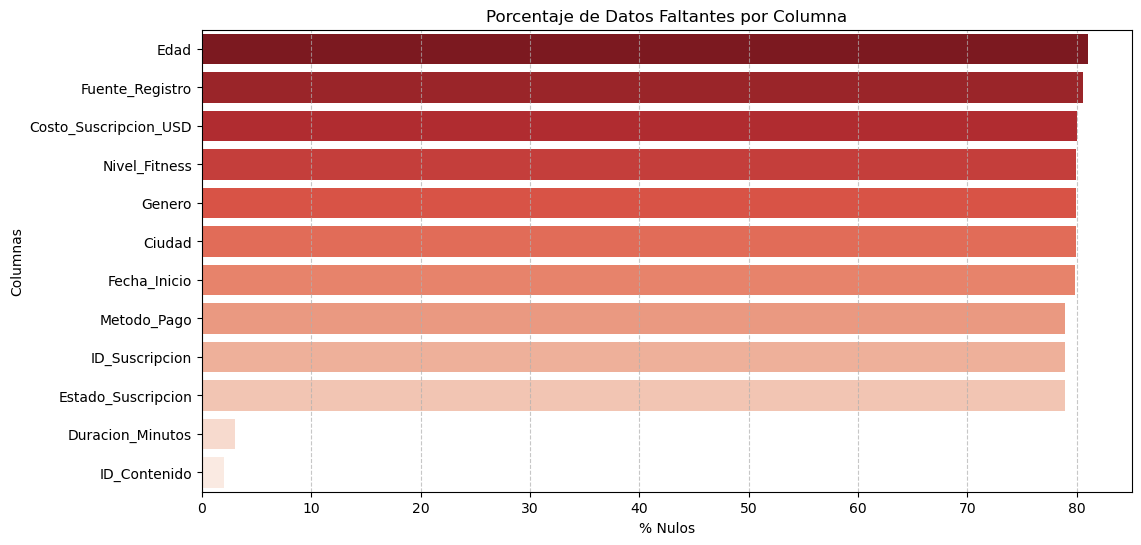

,Columnas,Nulos,% Nulos
6,Edad,9396,81.000000
9,Fuente_Registro,9344,80.551724
14,Costo_Suscripcion_USD,9282,80.017241
8,Nivel_Fitness,9276,79.965517
7,Genero,9276,79.965517
10,Ciudad,9276,79.965517
12,Fecha_Inicio,9259,79.818966
15,Metodo_Pago,9159,78.956897
11,ID_Suscripcion,9159,78.956897
13,Estado_Suscripcion,9159,78.956897


In [9]:
# 6. Diagnóstico de valores faltantes en el Dataset Maestro
nulos_conteo = df_maestro.isnull().sum()
nulos_porcentaje = (nulos_conteo / len(df_maestro)) * 100

df_nulos = pd.DataFrame({
    'Columnas': nulos_conteo.index,
    'Nulos': nulos_conteo.values,
    '% Nulos': nulos_porcentaje.values
}).sort_values(by='% Nulos', ascending=False)

# Visualización rápida
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_nulos[df_nulos['Nulos'] > 0], 
    x='% Nulos', 
    y='Columnas', 
    hue='Columnas',      # <--- Esto elimina el Warning
    palette='Reds_r', 
    legend=False         # <--- Esto mantiene el gráfico limpio
)
plt.title('Porcentaje de Datos Faltantes por Columna')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

display(df_nulos[df_nulos['Nulos'] > 0])

In [11]:
# 7. Limpieza Profunda Automática

# Separamos columnas por tipo de dato
cols_texto = df_maestro.select_dtypes(include=['object']).columns
cols_numeros = df_maestro.select_dtypes(include=['number']).columns

# A. Rellenamos TODO lo que sea texto con 'No Registrado'
df_maestro[cols_texto] = df_maestro[cols_texto].fillna('No Registrado')

# B. Rellenamos TODO lo que sea número con la mediana (o 0 si prefieres)
for col in cols_numeros:
    mediana = df_maestro[col].median()
    df_maestro[col] = df_maestro[col].fillna(mediana)

# C. Caso especial: Fecha_Inicio (Sintaxis actualizada)
if 'Fecha_Inicio' in df_maestro.columns:
    # Usamos los métodos directos ffill() y bfill() como sugiere el warning
    df_maestro['Fecha_Inicio'] = df_maestro['Fecha_Inicio'].ffill().bfill()

# Verificación final
nulos_final = df_maestro.isnull().sum().sum()
print(f"✅ Limpieza completada. Nulos restantes en el dataset: {nulos_final}")

if nulos_final == 0:
    print("🔥 ¡Perfecto! El Dataset Maestro está 100% limpio y listo para el análisis.")

✅ Limpieza completada. Nulos restantes en el dataset: 0
🔥 ¡Perfecto! El Dataset Maestro está 100% limpio y listo para el análisis.


C:\Users\ari90\AppData\Local\Temp\ipykernel_17100\2364240251.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_maestro['Fecha_Inicio'] = df_maestro['Fecha_Inicio'].fillna(method='ffill').fillna(method='bfill')
